In [1]:
import os, sys, toml
sys.path.append('..')

import matplotlib.pyplot as plt

import torch

from models.vision_transformer import ViT
from data.datasets import TimeSeriesDataset

%load_ext autoreload
%autoreload 2

In [2]:
config = toml.load('/glade/u/home/jshen/pruning-turbulence-vit/src/config/prune/attention_heads.toml')

In [3]:
dataset = TimeSeriesDataset(**config['validation_dataset'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
input, target = next(iter(dataloader))

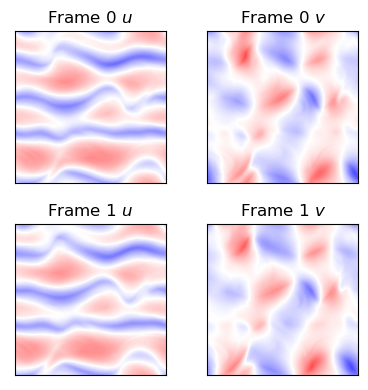

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(4, 4))

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

axs[0, 0].imshow(input[0, 0, 0].T, cmap='bwr', vmin=-5, vmax=5, aspect='equal')
axs[0, 0].set_title('Frame 0 $u$')

axs[0, 1].imshow(input[0, 1, 0].T, cmap='bwr', vmin=-5, vmax=5, aspect='equal')
axs[0, 1].set_title('Frame 0 $v$')

axs[1, 0].imshow(input[0, 0, 1].T, cmap='bwr', vmin=-5, vmax=5, aspect='equal')
axs[1, 0].set_title('Frame 1 $u$')

axs[1, 1].imshow(input[0, 1, 1].T, cmap='bwr', vmin=-5, vmax=5, aspect='equal')
axs[1, 1].set_title('Frame 1 $v$')

fig.tight_layout()

In [5]:
#checkpoint_file = '/glade/derecho/scratch/jshen/pruning-turbulence-vit/base/pretrained/best.tar'
checkpoint_file = '/glade/derecho/scratch/jshen/prune_base/attention_heads/checkpoints/20.tar'
state_dict = torch.load(checkpoint_file, map_location='cpu', weights_only=False)
model_state_dict = state_dict.pop('model_state', state_dict)
optimizer_state = state_dict.pop('optimizer_state', None)
model = ViT(**config['model'])
model.load_state_dict(model_state_dict)

blocks = model.encoder_blocks + model.decoder_blocks

In [6]:
activations = [dict() for _ in range(len(blocks))]

def get_hook(block_idx):
    def hook(module, x, y):
        B, L, E = x[0].shape
        qkv = y
        qkv = qkv.reshape(B, L, 3, 4, -1)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        activations[block_idx]['q'] = q
        activations[block_idx]['k'] = k
        activations[block_idx]['v'] = v

    return hook

hook_handles = [block.attn.qkv.register_forward_hook(get_hook(i)) for i, block in enumerate(blocks)]
model(input);

for handle in hook_handles: handle.remove()

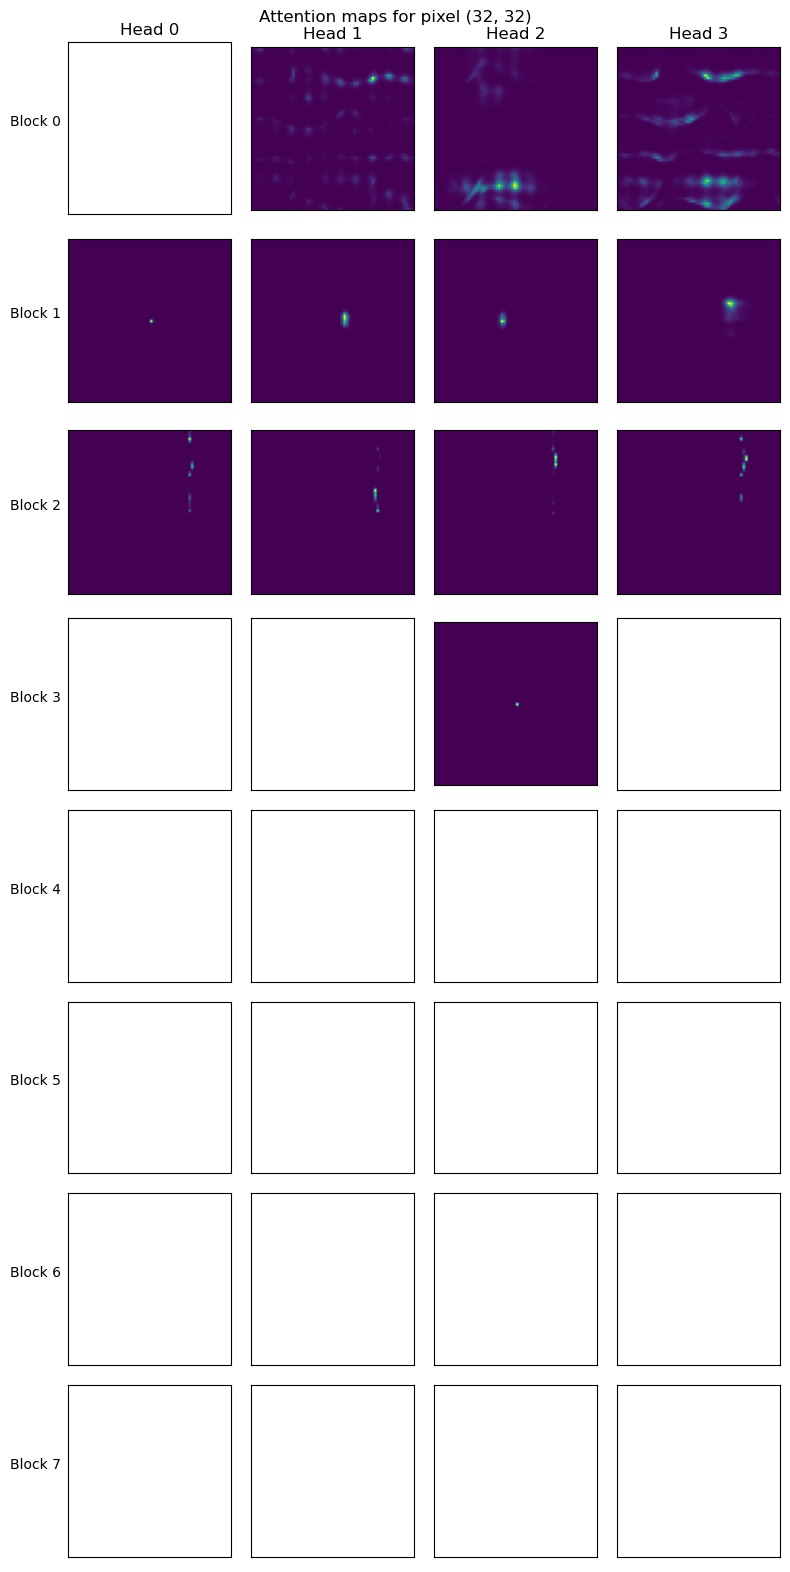

In [7]:
blocks = model.encoder_blocks + model.decoder_blocks

x, y = 32, 32

fig, axs = plt.subplots(len(blocks), 4, figsize=(2 * 4, 2 * len(blocks)))

for l, block in enumerate(blocks):
    for h in range(4):

        axs[l, h].set_xticks([])
        axs[l, h].set_yticks([])

        attn_map = activations[l]['q'] @ activations[l]['k'].transpose(-1, -2)
        if not torch.any(attn_map[0, h]): continue
        attn_map = torch.nn.functional.softmax(attn_map, dim=-1)
        attn_map = attn_map.reshape(1, 4, 64, 64, 64, 64).transpose(-1, -2)
        attn_map = attn_map[0, h, x, y, :, :]

        axs[l, h].imshow(attn_map.detach().cpu().numpy())
        # rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, color='r', linewidth=1)
        # axs[l, h].add_patch(rect)

for i, ax in enumerate(axs[0, :]): ax.set_title(f'Head {i}')
for i, ax in enumerate(axs[:, 0]): ax.set_ylabel(f'Block {i}', rotation=0, labelpad=20)

fig.suptitle(f'Attention maps for pixel ({x}, {y})')

fig.tight_layout()